<a href="https://colab.research.google.com/github/maggiemcc02/Adaptive_Meshing/blob/main/deBoor/Newton_and_deBoor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction 
In this notebook I will couple de Boor's algorithm (mesh solver) with the nonlinear, non-uniform physical solver which makes use of Newton's Method to solve the physical problem.

## The Method 
The coupling of this code follows the same logic as presented in *(2)deBoor_MeshSolver* except the physical solver approximates the solution of a nonlinear reaction - diffusion equation. That approximation, along with the grid used to find it, is then given to the de Boor Mesh Solver. The de Boor Mesh Solver uses de Boor's algorithm to create a new mesh by equidistributing the Mesh Density function. This new mesh is then given back to the physical solver which computes a new (and hopefully better) approximation to the physical problem. This process continues until we acquire a 'good enough' approximation on a 'good enough' mesh.

'good enough' - to be defined once the adequate stopping criteria for this coupling is defined.

## The Discretization 

The code I will adapt is the code written to solve a nonlinear BVP of the form 
$$ -\epsilon^2 u''(x) + b(x,u) = 0 $$
over the interval $(0,1)$ with 
$$ u(0) = g_0 \text{ and } u(1) = g_1 $$

Since this code is approximating on a non-uniform grid, I needed a second order centered approximation on a nonuniform grid. The formula for this approximation and it's derivation can be found in the notebook entitled *NonUniform_Finite_Differance_Approx.* Using this new approximation, I discretized the problem by replacing $u''(x)$ with the formula for this new approximation. I then brought all the terms to one side of the equation to obtain
$$ \frac{h_1U_{i+1} + h_2U_{i-1} - (h_1+h_2)U_i}{\frac{1}{2}(h_1h_2^2 + h_2h_1^2)} - \frac{b(U_i, x_i)}{ϵ^2} = 0 $$
which we can use to define  the system we want to solve : $G(U) = 0.$

The Jacobian of this system is defined as:
\\begin{cases} 
      \frac{h_1}{\frac{1}{2}(h_1h_2^2 + h_2h_2^2)} & \text{if } j = i+1, \\
      \frac{h_2}{\frac{1}{2}(h_1h_2^2 + h_2h_2^2)} & \text{if } j = i-1, \\
      \frac{-(h_1 + h_2)}{\frac{1}{2}(h_1h_2^2 + h_2h_1^2)} - \frac{b'(U_i, x_i)}{ϵ^2} & \text{ if } j = 1, \\
      0 & \text{otherwise} 
   \end{cases}

The code takes the vector of mesh points (including the boundaries) as an input. My code will take the boundaries out of this grid because it will not approximate the solution at the boundaries (solution given as boundary conditions). It will then compute the mesh spacing, $h_i,$ used to obtain each grid point, $x_i$ as $h_i = x_i - x_{i-1}.$ It will approximate the solution at these interior points, append the boundary conditions into the approximation, and return the approximation for the whole mesh. 

### By: Maggie McCarthy, June 2022

In [45]:
# import needed tools
import math
import numpy as np
from scipy.linalg import solve_banded
from numpy.linalg import norm
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Non-Uniform Nonlinear Physical Solver

The notebook where I create and test this solver : https://colab.research.google.com/drive/1YBNZJnpjLUEzcm4TjqQDVCMW56-AyqFW?usp=sharing

In [46]:
# Nonlinear, non-uniform, physical solver

def newton_method_bvp(G, J, grid, k, k_prime, x0, u_0, u_n, E, tol, max_iter):
  """
  Approximates the solution to a specific nonlinear system
  Parameters
  ---------
  G : Vector function
      Is the system of nonlinear equations
  
  J : Jacobian Matrix of G

  grid : vector of grid points

  k : Known function in ODE

  k_prime : derivative of k

  x0 :  Vector of initial guesses for each unknown. 
        If f has 4 unknowns, x0 has shape 4 X 1
  
  u_0, u_n : boundary conditions

  E : Epsilon (see text)

  tol : number 
        Tolerance

  max_iter: integer
            Max number of iterations

  Returns
  ------
  An approximation for the solutions of G(x) = 0 where G is a nonlinear system.
  """

  # Remove the first and last entries of the grid
  # this is because we already have the solution
  # at the boundary values (u_0 and u_1)
  
  #global mesh
  mesh = []
  for i in range(len(grid)):
    if i != 0: # if not first entry
      if i != (len(grid)-1): # if not last entry
        mesh.append([ grid[i][0] ]) # then add it to new vector
  mesh = np.array(mesh)
  

  # Calculate the mesh width (h) for each grid point
  # h_i = x_i - x_i-1

  h_list = []
  for i in range(1, len(grid)):
      h = grid[i][0] - grid[i-1][0]
      h_list.append( [h] )
  mesh_space = np.array(h_list)

  xn = x0 # sets initial guesses as xn for the first iteration of the loop
  
  for n in range(1, max_iter):

    # compute b = -G(X)
    
    b = (-1) * G(xn, mesh, mesh_space, k, u_0, u_n, E)

    # compute A = J(X)

    A = J(xn, mesh, mesh_space, k, k_prime, u_0, u_n, E)
    

    # solve the system with scipy's solve_banded
    # we can use this solver because A is tridiagonal

    delta = solve_banded((1,1), A, b)
    
    x_new = xn + delta
    

    if norm(x_new - xn) < tol:
      
      # x_new is our solution
      # add in the boundary conditions
      
      solutions_list = [[u_0]]
      for i in x_new:
        solutions_list.append(i)
      solutions_list.append([u_n])
      solutions = np.array(solutions_list)

      return solutions


    xn = x_new

  print('Max iterations reached and/or sequence is diverging')
  return None

In [47]:
# Our System

def G(x, mesh, mesh_spacing, k, u_0, u_n, E):

  """
  x : array of guesses
  mesh : vector of grid points
  mesh_spacing : vector of mesh widths
  k : our function in the ODE
  u_0, u_n : boundary conditions
  E : epsilon

  """
  g_list = []

  for i in range(len(x)):

    # set the grid point
    point = mesh[i][0]
    # set mesh width
    h1 = mesh_spacing[i][0]
    h2 = mesh_spacing[i+1][0]

    # create entries
    if (i == 0): # u_i-1 is u_0

      u_1 = x[i][0]
      u_2 = x[i+1][0]
      u_minus = u_0

      g_list.append( [ ( ( h1*u_2 + h2*u_minus - (h1 + h2)*u_1 ) \
                        / ( (1/2) * (h1*(h2**2) + h2*(h1**2)) ) \
                        - ( (k(u_1, point)) / (E**2) ) ) ] )
   
      
    elif i == (len(x) - 1): # U_i+1 is u_n

      u_1 = x[i][0]
      u_2 = u_n
      u_minus = x[i-1][0]  

      g_list.append( [ ( ( h1*u_2 + h2*u_minus - (h1 + h2)*u_1 ) \
                        / ( (1/2) * (h1*(h2**2) + h2*(h1**2)) ) \
                        - ( (k(u_1, point)) / (E**2) ) ) ] )

    else:

      u_1 = x[i][0]
      u_2 = x[i+1][0]
      u_minus = x[i-1][0]  

      g_list.append( [ ( ( h1*u_2 + h2*u_minus - (h1 + h2)*u_1 ) \
                        / ( (1/2) * (h1*(h2**2) + h2*(h1**2)) ) \
                        - ( (k(u_1, point)) / (E**2) ) ) ] )

      
    
    

  # create array 
  G = np.array(g_list)
  return G

In [48]:
# Our Jacobian

def J(x, mesh, mesh_spacing, k, k_prime, u_0, u_n, E):

  """
  x : array of guesses
  mesh : vector of grid points
  mesh_spacing : vector of mesh widths
  k : function in ODE
  k_prime : derivaive of function in ODE
  E : epsilon

  """


  main  = []
  upper = []
  lower = []
 

  for i in range(len(x)):

    # set grid point
    point = mesh[i][0]
    # set mesh width
    h1 = mesh_spacing[i][0]
    h2 = mesh_spacing[i+1][0]



    # create diagonals 

    if i == 0: # first row

      main.append( ( (-1*(h1+h2)) / ( (1/2)*(h1*(h2**2) + h2*(h1**2)) ) ) - ( (1 / (E**2)) * ( k_prime(x[i][0], point)) ) )
      upper.append(0)
      upper.append( h1 / ( (1/2)* (h1*(h2**2) + h2*(h1**2)) ) )

    elif i == (len(x)-1): # last row

      main.append( ( (-1*(h1+h2)) / ( (1/2)*(h1*(h2**2) + h2*(h1**2)) ) ) - ( (1 / (E**2)) * ( k_prime(x[i][0], point)) ) )
      lower.append( h2 / ( (1/2)* (h1*(h2**2) + h2*(h1**2)) ) )
      lower.append(0)

    else: 

      upper.append( h1 / ( (1/2)* (h1*(h2**2) + h2*(h1**2)) ) )
      main.append( ( (-1*(h1+h2)) / ( (1/2)*(h1*(h2**2) + h2*(h1**2)) ) ) - ( (1 / (E**2)) * ( k_prime(x[i][0], point)) ) )
      lower.append( h2 / ( (1/2)* (h1*(h2**2) + h2*(h1**2)) ) )

    

  # create banded array
  jacob = np.array([upper, main, lower])

  return jacob 

## Test The Physical Solver

I will now try and reproduce the three plots (three solutions) shown in Figure 1 of Kopteva's paper. 


In [49]:
# define our bvp

def k(u, t):
  return u*(u-1)*(u-t-(3/2))

def k_prime(u, t):
  return 3*u**2 - 2*u*t + (-10*u + 3) / 2 + t

u_0 = 3/2
u_n = 1/2

In [50]:
# set uniform grid

uni_grid = np.linspace(0, 1, 100)
uni_grid = np.array([uni_grid]).T

# Set first guess u(t) = 0

guess1 = []
for i in range(len(uni_grid)):
  if i != 0:
    if i != (len(uni_grid)-1):
      val = [ 0 ]
      guess1.append(val)
guess1 = np.array( guess1 )

# set second guess u(t) = t

guess2 = []
for i in range(len(uni_grid)):
  if i != 0:
    if i != (len(uni_grid)-1):
      val = [ uni_grid[i][0] ]
      guess2.append(val)
guess2 = np.array( guess2 )


# set third guess u(t) = t + 3/2

guess3 = []
for i in range(len(uni_grid)):
  if i != 0:
    if i != (len(uni_grid)-1):
      val = [ uni_grid[i][0] + 3/2 ]
      guess3.append(val)
guess3 = np.array( guess3 )

Approximations of the Three Solutions for our Test Problems (100 grid points, eps = 0.01)




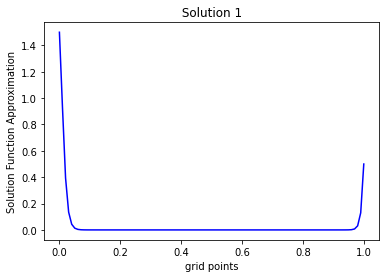

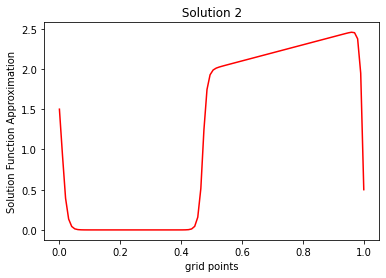

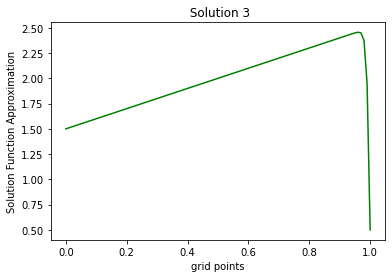

In [51]:
uniform1 = newton_method_bvp(G, J, uni_grid, k, k_prime, guess1, u_0, u_n, 0.01, 1e-12, 100)
uniform2 = newton_method_bvp(G, J, uni_grid, k, k_prime, guess2, u_0, u_n, 0.01, 1e-12, 100)
uniform3 = newton_method_bvp(G, J, uni_grid, k, k_prime, guess3, u_0, u_n, 0.01, 1e-12, 100)


print('Approximations of the Three Solutions for our Test Problems (100 grid points, eps = 0.01)')
print()
print()


# plot 1

plt.plot(uni_grid, uniform1, 'b')
plt.xlabel('grid points')
plt.ylabel('Solution Function Approximation')
plt.title(" Solution 1 ")
plt.show()

# plot 2

plt.plot(uni_grid, uniform2, 'r')
plt.xlabel('grid points')
plt.ylabel('Solution Function Approximation')
plt.title(" Solution 2 ")
plt.show()

# plot 3

plt.plot(uni_grid, uniform3, 'g')
plt.xlabel('grid points')
plt.ylabel('Solution Function Approximation')
plt.title(" Solution 3")
plt.show()



# de Boor's Algorithm (Mesh Solver) 

The notebook where I created and tested this method : 

 https://colab.research.google.com/drive/1bGt-mo34X-DQ7LtHbdjcpU7eBSABiJqz?usp=sharing

## Mesh Density Function

In [52]:
# mesh density function for interior nodes without prints

def interior_M(Uc, Ua, xc, xb, xa):

  """
  Uc : U_i+1 
  Ua : U_i-1
  xc, xb, xa : corresponding grid points
  """

  U0 = Ua # U_i-1
  U2 = Uc # U_i+1

  h1 = xb - xa
  h2 = xc - xb

  ux = (U2 - U0) / (h2 + h1)

  approx = np.sqrt(1 + (ux)**2)

  return approx

In [53]:
# mesh density function for endpoints without prints

def endpoint_M(Ub, Ua, xb, xa):
  """
  Ub : U_i+1 or Ui
  Ua : Ui or U_i-1
  xb, xa : corresponding grid points
  """
  ux = (Ub - Ua) / (xb - xa)


  approx = np.sqrt( 1 + (ux)**2)

  return approx

In [54]:
# code to generate M values on a given grid
# same as before without prints

def M_calc(U, grid):


  rho = [] # empty list to save M values

  rho.append(endpoint_M(U[1][0], U[0][0], grid[1][0], grid[0][0])) # add M value at first grid point using forward approx

  for i in range(len(grid)-2): # add M values for interior nodes


    # set values of U and y to pass to mesh density function

    U0 = U[i][0]
    U2 = U[i+2][0]
    x0 = grid[i][0]
    x1 = grid[i+1][0]
    x2 = grid[i+2][0]

    val = interior_M(U2, U0, x2, x1, x0) # compute mesh density
    
    rho.append(val)


  rho.append(endpoint_M(U[-1][0], U[-2][0], grid[-1][0], grid[-2][0])) # add M value for last grid point

  rho = np.array([rho]).T

  return rho

## P(x) Function 
$$P(y_j) = \sum^{j}_{i=1} (y_i - y_{i-1}) \frac{\rho(y_i) + \rho(y_{i-1})}{2} \text{ for } j = 1, \dots, N-1.$$

In [55]:
# define P without prints

def P(j, old_mesh, rho):

  """
  j : index of grid point we want to calculate P at j = 1, ..., N-1
  
  old_mesh : current mesh / old mesh

  rho : vector of mesh density function values at each grid point in old_mesh

  """

  p_j = 0

  for i in range(1, j+1):
    

    y1 = old_mesh[i-1][0]
    y2 = old_mesh[i][0]
    M1 = rho[i-1][0]
    M2 = rho[i][0]

    val = (y2 - y1) * ( (M2 + M1) / 2)


    p_j += val

  return p_j

## The Mesh Solver (de Boor)

NOTE : the print statements are commented out

In [56]:
def equidistribute(oldmesh, P, rho, uni_grid, x0, xn):
  """
  oldmesh : current mesh we are updating with this code

  P : function defined in Russell and Huang which represents the integral of the linearized mesh density function

  rho : value of the mesh density function at each point on the oldmesh

  uni_grid : a uniform grid with the same number of points and on the same interval the oldmesh

  x0, xn : first and last grid points
  """

  # compute P(y) for each y in oldmesh

  #print('Computing P(y) values:')

  P_list = [0] # P(a) = 0

  for q in range(1, len(oldmesh)): # q = second grid point, ..., last grid point

    P_list.append(P(q, oldmesh, rho)) 

  #print('list of P values')
  #print(P_list)
  #print()

  # main code to compute the new grid points

  newmesh = [x0] # add in boundary condition x(0) = 0

  #print('Computing new mesh points, xj')
  #print()
  #print()

  for j in range(1, len(oldmesh)-1): # j = second grid point, ..., second last grid point 

    #print('changing', j, 'entry of mesh')
    #print()

    # compute xi * P(b)

    xi = uni_grid[j][0] # THIS COULD BE REPLACED WITH j/N

    P_b = P_list[-1] # P(b) is last P value in P_list

    xi_pb = xi * P_b # compute xi * P(b)

    #print('xi =', xi)
    #print('P(b)=', P_b)
    #print('xi * P(b)', xi_pb)


    # find what interval on the old mesh xi*P(b) is in

    for i in range(1, len(oldmesh)):


      P_y2 = P_list[i] #P(y_i)
      P_y1 = P_list[i-1] #P(y_i-1)


      if ((xi_pb > P_y1) and (xi_pb <= P_y2)): # if P(y_i-1) < xi*P(b) <= P(y_i)
        
        # set k = i

        k = i

        #print("Since", xi_pb, "is between", P_y1, " which is the", i-1, "entry and",P_y2," which is the", i, "entry we set k =", k)

        break

    
    # compute the new mesh point

    #print('k = ', k)


    a = oldmesh[k-1][0] # a = y_k-1

    b = 2 * ( xi_pb - P_list[k-1] ) # b = 2 * (xi*P(b) - P(y_k-1))

    c = rho[k-1][0] + rho[k][0] # c = M(y_k-1) + M(y_k)

    new_x = a + b / c # new_x = y_k-1 + ( 2 * (xi*P(b) - P(y_k-1))) / (M(y_k-1) + M(y_k))

    #print('y_k-1 = ', a)
    #print('P(y_k-1) = ', P_list[k-1])
    #print('rho(y_k-1), rho(y_k) = ',rho[k-1][0], rho[k][0] )
    #print('numerator = ', b)
    #print('denominator = ', c)
    #print()
    #print('The new x is ', new_x)
    #print()
    #print()

    newmesh.append(new_x) # save new grid point to mesh

  newmesh.append(xn) # save endpoint to end of mesh
  newmesh = np.array([newmesh]).T # make mesh a column vector 


  return newmesh

# Couple for 1 Iteration ( 100 grid points, ϵ = 0.01 )

In [57]:
# define our bvp

def k(u, t):
  return u*(u-1)*(u-t-(3/2))

def k_prime(u, t):
  return 3*u**2 - 2*u*t + (-10*u + 3) / 2 + t

u_0 = 3/2
u_n = 1/2

## First Solution - Initial Guess of $u(x) = 0.$

In [58]:
# set grid

grid = np.linspace(0, 1, 100)
grid = np.array([grid]).T

# set xi grid 

uni_grid = np.linspace(0, 1, 100)
uni_grid = np.array([uni_grid]).T

# set initial guess u(t) = t

guess = []
for i in range(len(uni_grid)):
  if i != 0:
    if i != (len(uni_grid)-1):
      val = [ 0 ]
      guess.append(val)
guess = np.array( guess )

# set U using nonlinear physical solver

U = newton_method_bvp(G, J, uni_grid, k, k_prime, guess, u_0, u_n, 0.01, 1e-12, 100)

# Compute M values (approximations)

M = M_calc(U, grid)

# equidistribute

new_mesh = equidistribute(grid, P, M, uni_grid, 0, 1 )
print('final mesh')
print(new_mesh)
print()


final mesh
[[0.00000000e+00]
 [5.26370392e-04]
 [1.05274078e-03]
 [1.57911118e-03]
 [2.10548157e-03]
 [2.63185196e-03]
 [3.15822235e-03]
 [3.68459274e-03]
 [4.21096314e-03]
 [4.73733353e-03]
 [5.26370392e-03]
 [5.79007431e-03]
 [6.31644470e-03]
 [6.84281510e-03]
 [7.36918549e-03]
 [7.89555588e-03]
 [8.42192627e-03]
 [8.94829666e-03]
 [9.47466706e-03]
 [1.00010374e-02]
 [1.06072154e-02]
 [1.12321050e-02]
 [1.18569945e-02]
 [1.24818841e-02]
 [1.31067736e-02]
 [1.37316632e-02]
 [1.43565527e-02]
 [1.49814422e-02]
 [1.56063318e-02]
 [1.62312213e-02]
 [1.68561109e-02]
 [1.74810004e-02]
 [1.81058900e-02]
 [1.87307795e-02]
 [1.93556691e-02]
 [1.99805586e-02]
 [2.08719447e-02]
 [2.19096239e-02]
 [2.29473032e-02]
 [2.39849824e-02]
 [2.50226616e-02]
 [2.60603408e-02]
 [2.70980200e-02]
 [2.81356993e-02]
 [2.91733785e-02]
 [3.02110577e-02]
 [3.25793124e-02]
 [3.50769691e-02]
 [3.75746259e-02]
 [4.00722827e-02]
 [4.65535536e-02]
 [5.83174898e-02]
 [8.51595304e-02]
 [1.14512926e-01]
 [1.43871885e-01]

## Second Solution - Initial Guess of $u(x) = x + \frac{3}{2}.$

In [59]:
# set grid

grid = np.linspace(0, 1, 100)
grid = np.array([grid]).T

# set xi grid 

uni_grid = np.linspace(0, 1, 100)
uni_grid = np.array([uni_grid]).T

# set initial guess u(t) = t

guess = []
for i in range(len(uni_grid)):
  if i != 0:
    if i != (len(uni_grid)-1):
      val = [ uni_grid[i][0] + 3/2 ]
      guess.append(val)
guess = np.array( guess )

# set U using nonlinear physical solver

U = newton_method_bvp(G, J, uni_grid, k, k_prime, guess, u_0, u_n, 0.01, 1e-12, 100)

# Compute M values (approximations)

M = M_calc(U, grid)

# equidistribute

new_mesh = equidistribute(grid, P, M, uni_grid, 0, 1 )
print('final mesh')
print(new_mesh)
print()

final mesh
[[0.        ]
 [0.02366551]
 [0.04733102]
 [0.07099653]
 [0.09466203]
 [0.11832754]
 [0.14199305]
 [0.16565856]
 [0.18932407]
 [0.21298958]
 [0.23665509]
 [0.2603206 ]
 [0.2839861 ]
 [0.30765161]
 [0.33131712]
 [0.35498263]
 [0.37864814]
 [0.40231365]
 [0.42597916]
 [0.44964467]
 [0.47331017]
 [0.49697568]
 [0.52064119]
 [0.5443067 ]
 [0.56797221]
 [0.59163772]
 [0.61530323]
 [0.63896874]
 [0.66263424]
 [0.68629975]
 [0.70996526]
 [0.73363077]
 [0.75729628]
 [0.78096179]
 [0.8046273 ]
 [0.8282928 ]
 [0.85195831]
 [0.87562383]
 [0.89928949]
 [0.92296527]
 [0.94710509]
 [0.96680778]
 [0.97148705]
 [0.97379058]
 [0.9760941 ]
 [0.97839763]
 [0.98002098]
 [0.98058974]
 [0.9811585 ]
 [0.98172726]
 [0.98229602]
 [0.98286478]
 [0.98343355]
 [0.98400231]
 [0.98457107]
 [0.98513983]
 [0.98570859]
 [0.98627735]
 [0.98684611]
 [0.98741487]
 [0.98798363]
 [0.98855239]
 [0.98912115]
 [0.98968991]
 [0.99007826]
 [0.99036174]
 [0.99064522]
 [0.9909287 ]
 [0.99121217]
 [0.99149565]
 [0.99177

## Third Solution - Initial Guess of $u(x) = x.$

In [60]:
# set grid

grid = np.linspace(0, 1, 100)
grid = np.array([grid]).T

# set xi grid 

uni_grid = np.linspace(0, 1, 100)
uni_grid = np.array([uni_grid]).T

# set initial guess u(t) = t

guess = []
for i in range(len(uni_grid)):
  if i != 0:
    if i != (len(uni_grid)-1):
      val = [ uni_grid[i][0] ]
      guess.append(val)
guess = np.array( guess )

# set U using nonlinear physical solver

U = newton_method_bvp(G, J, uni_grid, k, k_prime, guess, u_0, u_n, 0.01, 1e-12, 100)

# Compute M values (approximations)

M = M_calc(U, grid)

# equidistribute

new_mesh = equidistribute(grid, P, M, uni_grid, 0, 1 )
print('final mesh')
print(new_mesh)
print()


final mesh
[[0.        ]
 [0.00117164]
 [0.00234327]
 [0.00351491]
 [0.00468655]
 [0.00585818]
 [0.00702982]
 [0.00820145]
 [0.00937309]
 [0.01062778]
 [0.0120187 ]
 [0.01340963]
 [0.01480056]
 [0.01619149]
 [0.01758242]
 [0.01897335]
 [0.02047145]
 [0.0227812 ]
 [0.02509095]
 [0.0274007 ]
 [0.02971044]
 [0.03443618]
 [0.03999566]
 [0.06237088]
 [0.12687533]
 [0.19222481]
 [0.25757429]
 [0.32292377]
 [0.38827308]
 [0.43673892]
 [0.44631738]
 [0.45059012]
 [0.45467161]
 [0.45636995]
 [0.45806829]
 [0.45976663]
 [0.46146497]
 [0.4631633 ]
 [0.4647911 ]
 [0.46593266]
 [0.46707421]
 [0.46821577]
 [0.46935733]
 [0.47049888]
 [0.47164044]
 [0.472782  ]
 [0.47392356]
 [0.47513101]
 [0.47650939]
 [0.47788776]
 [0.47926614]
 [0.48064452]
 [0.48202289]
 [0.48340127]
 [0.48477965]
 [0.48754467]
 [0.49038258]
 [0.49322049]
 [0.49807799]
 [0.50771526]
 [0.54087751]
 [0.58694131]
 [0.63315014]
 [0.6793592 ]
 [0.72556826]
 [0.77177732]
 [0.81798638]
 [0.86419544]
 [0.91040567]
 [0.9589752 ]
 [0.97235

# Couple for 30 Iterations (30 Meshes, 100 grid points, ϵ = 0.01) 

## First Solution - Initial Guess of $u(x) = 0.$

Mesh #    l2 Norm of Old Mesh - New Mesh          l2 Norm of Old U - New U
________________________________________________________________________________
1         2.4061790757235233                       5.777522205294615
2         0.01863641456994043                       0.3784392897193498
3         0.006602383809062188                       0.013665650289171468
4         0.0008095279632483083                       0.0016931457455366804
5         0.00030569990995169005                       0.0005563880950004074
6         8.663571844501501e-05                       0.00025388346751301647
7         4.603822279400983e-05                       9.94474629339703e-05
8         1.9532085985678307e-05                       3.780944594551673e-05
9         9.062796482237571e-06                       1.500241528750273e-05
10         3.754325697688782e-06                       6.086827486138015e-06
11         1.1800977061897835e-06                       2.105675665201802e-06
12         2.8105

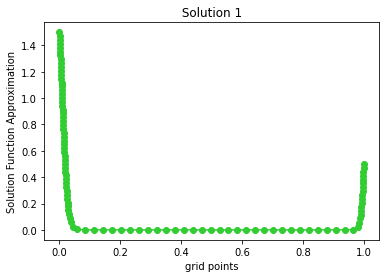

In [61]:
# create table to print results

print('Mesh #    l2 Norm of Old Mesh - New Mesh          l2 Norm of Old U - New U')
print('_'*80)

# set grids

grid = np.linspace(0, 1, 100)

mesh = np.array([grid]).T # initial mesh
uni_grid = np.array([grid]).T # uniform xi

# set initial guess u(t) = 0

guess = []
for i in range(len(mesh)):
  if i != 0:
    if i != (len(mesh)-1):
      val = [ 0 ]
      guess.append(val)
guess = np.array( guess )

# loop to couple codes

for i in range(30): # couple code 30 times


  print(i + 1, end = '         ')

  # physical solver to approximate U

  U = newton_method_bvp(G, J, mesh, k, k_prime, guess, u_0, u_n, 0.01, 1e-12, 100)


  # compute approximate M(x)


  M_vals = M_calc(U, mesh)


  # equidistribute (mesh solver with de Boor)

  new_mesh = equidistribute(mesh, P, M_vals, uni_grid, 0, 1)


  # print norm(old mesh - new mesh)

  print(norm(abs(new_mesh-mesh)), end = '                       ')

  # update the mesh

  mesh = new_mesh

  # compute new U

  new_U = newton_method_bvp(G, J, mesh, k, k_prime, guess, u_0, u_n, 0.01, 1e-12, 100)


  print(norm(abs(new_U - U)))

print()
plt.plot(mesh, new_U, 'limegreen', marker = "o")
plt.xlabel('grid points')
plt.ylabel('Solution Function Approximation')
plt.title(" Solution 1 ")
plt.show()

  

## Second Solution - Initial Guess of $u(x) = x + \frac{3}{2}.$

Mesh #    l2 Norm of Old Mesh - New Mesh          l2 Norm of Old U - New U
________________________________________________________________________________
1         3.225552007326674                       7.589370055413662
2         0.01556980908613934                       0.7997195247664944
3         0.007923423561706352                       0.029941433339383552
4         0.0015751491805402816                       0.007587593521402176
5         0.00054203292381872                       0.0016737463002710648
6         0.00032588993161977237                       0.0016830051668666247
7         0.00020886873803721022                       0.001323236591895104
8         9.131506589555585e-05                       0.0004007257536167408
9         6.694975851830323e-05                       0.0002850370907610941
10         3.4712749456167586e-05                       0.00014674073253972072
11         1.7744425526050897e-05                       7.281207944731664e-05
12         9.4722665

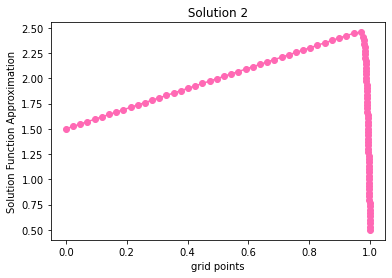

In [62]:
# create table to print results

print('Mesh #    l2 Norm of Old Mesh - New Mesh          l2 Norm of Old U - New U')
print('_'*80)

# set grids

grid = np.linspace(0, 1, 100)

mesh = np.array([grid]).T # initial mesh
uni_grid = np.array([grid]).T # uniform xi

# set initial guess u(t) = t + 3/2

guess = []
for i in range(len(mesh)):
  if i != 0:
    if i != (len(mesh)-1):
      val = [ mesh[i][0] + 3/2 ]
      guess.append(val)
guess = np.array( guess )

# loop to couple codes

for i in range(30): # couple code 30 times


  print(i + 1, end = '         ')

  # physical solver to approximate U

  U = newton_method_bvp(G, J, mesh, k, k_prime, guess, u_0, u_n, 0.01, 1e-12, 100)


  # compute approximate M(x)


  M_vals = M_calc(U, mesh)


  # equidistribute (mesh solver with de Boor)

  new_mesh = equidistribute(mesh, P, M_vals, uni_grid, 0, 1)


  # print norm(old mesh - new mesh)

  print(norm(abs(new_mesh-mesh)), end = '                       ')

  # update the mesh

  mesh = new_mesh

  # compute new U

  new_U = newton_method_bvp(G, J, mesh, k, k_prime, guess, u_0, u_n, 0.01, 1e-12, 100)


  print(norm(abs(new_U - U)))

print()
plt.plot(mesh, new_U, 'hotpink', marker = "o")
plt.xlabel('grid points')
plt.ylabel('Solution Function Approximation')
plt.title(" Solution 2 ")
plt.show()

## Third Solution - Initial Guess of $u(x) = x.$ - ISSUE HERE

In [63]:
# # create table to print results
# #print('Mesh #    l2 Norm of Old Mesh - New Mesh          l2 Norm of Old U - New U')
# #print('_'*80)

# # set grids

# grid = np.linspace(0, 1, 100)

# mesh = np.array([grid]).T # initial mesh
# uni_grid = np.array([grid]).T # uniform xi

# # set initial guess u(x) = x

# guess = []
# for i in range(len(mesh)):
#   if i != 0:
#     if i != (len(mesh)-1):
#       val = [  mesh[i][0]  ]
#       guess.append(val)
# guess = np.array( guess )


# # loop to couple codes

# for i in range(30): # couple code 30 times


#   #print(i + 1, end = '         ')

#   # physical solver to approximate U

#   U = newton_method_bvp(G, J, mesh, k, k_prime, guess, u_0, u_n, 0.01, 1e-12, 100)

#   if i == 0: # plot our approximation on uniform grid
#     plt.plot(mesh, U, 'purple', marker = "o")
#     plt.xlabel('grid points')
#     plt.ylabel('Solution Function Approximation')
#     plt.title(" Solution 3 with Uniform Mesh ")
#     plt.show()

#   # compute approximate M(x)


#   M_vals = M_calc(U, mesh)


#   # equidistribute (mesh solver with de Boor)

#   new_mesh = equidistribute(mesh, P, M_vals, uni_grid, 0, 1)

#   # print norm(old mesh - new mesh)

#   #print(norm(abs(new_mesh-mesh)), end = '                       ')

#   # update the mesh

#   mesh = new_mesh

#   # compute new U

#   new_U = newton_method_bvp(G, J, mesh, k, k_prime, guess, u_0, u_n, 0.01, 1e-12, 100)

#   plt.plot(mesh, new_U, 'purple', marker = "o", label = "Approximation")
#   plt.xlabel('grid points')
#   plt.ylabel('Solution Function Approximation')
#   plt.title(" Solution 3 with de Boor Mesh")
#   plt.legend()
#   plt.show()


#   #print(norm(abs(new_U - U)))

### Using my Uniform Approximation as the Initial Guess

To try and overcome this issue in which my initial guess is bad, I will generate an approximation on a uniform grid using the initial guess $u(x) = x.$ I will then use this approximation as my initial guess for the approximations I will compute when I couple the codes.

In [64]:
# create table to print results
print('Mesh #    l2 Norm of Old Mesh - New Mesh          l2 Norm of Old U - New U')
print('_'*80)

# set grids

grid = np.linspace(0, 1, 100)

mesh = np.array([grid]).T # initial mesh
uni_grid = np.array([grid]).T # uniform xi

# set initial guess u(x) = x

guess = []
for i in range(len(mesh)):
  if i != 0:
    if i != (len(mesh)-1):
      val = [  mesh[i][0]  ]
      guess.append(val)
guess = np.array( guess )

# approximate on a uniform mesh using this guess

U = newton_method_bvp(G, J, mesh, k, k_prime, guess, u_0, u_n, 0.01, 1e-12, 100)

# set new initial guess as U

guess = []
for i in range(len(U)):
  if i != 0:
    if i != (len(U)-1):
      val = [  U[i][0]  ]
      guess.append(val)
guess = np.array( guess )


# loop to couple codes

for i in range(50): # couple code 50 times


  print(i + 1, end = '         ')

  # physical solver to approximate U

  U = newton_method_bvp(G, J, mesh, k, k_prime, guess, u_0, u_n, 0.01, 1e-12, 100)

  # compute approximate M(x)


  M_vals = M_calc(U, mesh)


  # equidistribute (mesh solver with de Boor)

  new_mesh = equidistribute(mesh, P, M_vals, uni_grid, 0, 1)

  # print norm(old mesh - new mesh)

  print(norm(abs(new_mesh-mesh)), end = '                       ')

  # update the mesh

  mesh = new_mesh

  # compute new U

  new_U = newton_method_bvp(G, J, mesh, k, k_prime, guess, u_0, u_n, 0.01, 1e-12, 100)


  print(norm(abs(new_U - U)))

Mesh #    l2 Norm of Old Mesh - New Mesh          l2 Norm of Old U - New U
________________________________________________________________________________
1         1.2279108449984255                       6.810273358881453
2         0.029255269378838513                       0.930236497464942
3         0.017693773941847884                       0.059442111626834236
4         0.0073953757171618785                       0.04632978928001769
5         0.005802928506415137                       0.08476570119048639
6         0.00401612349915677                       0.06641255288024654
7         0.0026663381361914985                       0.029512729871469447
8         0.002123866508507244                       0.02783454702611845
9         0.0015928356237607517                       0.020732331431635075
10         0.001173362566569859                       0.014358071849124982
11         0.0008969724869272492                       0.011337614942792404
12         0.0006767160038841523     

### Using Linear Interpolation to Construct an Initial Guess

I will now first approximate the solution with only 10 grid points. I will then perform linear interpolation on the approximation. Finally, I will evaluate the spline over my initial uniform grid and use the result as my initial guess.

NOTE: This is the strategy explained in an email by Dr. Haynes.

In [65]:
# # create table to print results
# print('Mesh #    l2 Norm of Old Mesh - New Mesh          l2 Norm of Old U - New U')
# print('_'*80)

# # grid of 10 points

# small_grid = np.linspace(0, 1, 10)
# small_mesh = np.array([small_grid]).T # mesh of 10 points

# # set initial guess u(x) = x

# small_guess = []
# for i in range(len(small_mesh)):
#   if i != 0:
#     if i != (len(small_mesh)-1):
#       val = [  small_mesh[i][0]  ]
#       small_guess.append(val)
# small_guess = np.array( small_guess )

# # approximate over 10 points

# U = newton_method_bvp(G, J, small_mesh, k, k_prime, small_guess, u_0, u_n, 0.01, 1e-12, 100)

# U_list = [] # make U 1D
# for i in range(len(U)):
#   U_list.append(U[i][0])

# # linear interpolation

# linear = interp1d(small_grid, U_list)

# # set grids for coupling

# grid = np.linspace(0, 1, 100)

# mesh = np.array([grid]).T # initial mesh
# uni_grid = np.array([grid]).T # uniform xi

# # evaluate initial mesh using linear interpolation function to create guess

# guess = []
# for i in range(len(mesh)):
#   if i != 0:
#     if i != (len(mesh)-1):
#       guess.append([ linear(mesh[i][0]) ])
# guess = np.array(guess)

# # loop to couple codes

# for i in range(50): # couple code 50 times

#   print(i + 1, end = '         ')

#   # physical solver to approximate U

#   U = newton_method_bvp(G, J, mesh, k, k_prime, guess, u_0, u_n, 0.01, 1e-12, 100)

#   # compute approximate M(x)

#   M_vals = M_calc(U, mesh)


#   # equidistribute (mesh solver with de Boor)

#   new_mesh = equidistribute(mesh, P, M_vals, uni_grid, 0, 1)

#   # print norm(old mesh - new mesh)

#   print(norm(abs(new_mesh-mesh)), end = '                       ')

#   # update the mesh

#   mesh = new_mesh

#   # compute new U

#   new_U = newton_method_bvp(G, J, mesh, k, k_prime, guess, u_0, u_n, 0.01, 1e-12, 100)

#   print(norm(abs(new_U - U)))

# General Code for Coupling

In [71]:
# create table to print results
print('Mesh #    l2 Norm of Old Mesh - New Mesh          l2 Norm of Old U - New U')
print('_'*80)

# set grids

grid = np.linspace(0, 1, 100)

mesh = np.array([grid]).T # initial mesh
uni_grid = np.array([grid]).T # uniform xi

# set initial guess u(x) = x

guess = []
for i in range(len(mesh)):
  if i != 0:
    if i != (len(mesh)-1):
      val = [  mesh[i][0]  ]
      guess.append(val)
guess = np.array( guess )

# approximate on a uniform mesh using this guess

U = newton_method_bvp(G, J, mesh, k, k_prime, guess, u_0, u_n, 0.01, 1e-12, 100)

# set new initial guess as U

guess = []
for i in range(len(U)):
  if i != 0:
    if i != (len(U)-1):
      val = [  U[i][0]  ]
      guess.append(val)
guess = np.array( guess )


# loop to couple codes

for i in range(50): # couple code 50 times


  print(i + 1, end = '         ')

  # compute mesh density function

  M_vals = M_calc(U, mesh)

  # equidistribute (mesh solver with de Boor)

  new_mesh = equidistribute(mesh, P, M_vals, uni_grid, 0, 1)

  # print norm(old mesh - new mesh)

  print(norm(abs(new_mesh-mesh)), end = '                       ')

  # update the mesh

  mesh = new_mesh

  # set current U as guess
  
  guess = []
  for i in range(len(U)):
    if i != 0:
      if i != (len(U)-1):
        val = [  U[i][0]  ]
        guess.append(val)
  guess = np.array( guess )

  # compute new U

  new_U = newton_method_bvp(G, J, mesh, k, k_prime, guess, u_0, u_n, 0.01, 1e-12, 100)


  print(norm(abs(new_U - U)))

  # set new_U as U

  U = new_U

Mesh #    l2 Norm of Old Mesh - New Mesh          l2 Norm of Old U - New U
________________________________________________________________________________
1         1.227910844998425                       6.8102733588814575
2         0.029255269378840536                       0.9302364974646528
3         0.01769377394185003                       0.059442111626335385
4         0.007395375717153334                       0.04632978927856383
5         0.005802928506436691                       0.08476570119216204
6         0.004016123499144592                       0.06641255287930718
7         0.00266633813619899                       0.0295127298727336
8         0.002123866508487669                       0.027834547026786435
9         0.0015928356237312914                       0.020732331428177788
10         0.001173362566608103                       0.014358071851028394
11         0.0008969724869222991                       0.011337614942291335
12         0.0006767160038955063        

In [ ]:
# create table to print results
print('Mesh #    l2 Norm of Old Mesh - New Mesh          l2 Norm of Old U - New U')
print('_'*80)

# set grids

grid = np.linspace(0, 1, 100)

mesh = np.array([grid]).T # initial mesh
uni_grid = np.array([grid]).T # uniform xi

# set initial guess u(x) = x

guess = []
for i in range(len(mesh)):
  if i != 0:
    if i != (len(mesh)-1):
      val = [  mesh[i][0]  ]
      guess.append(val)
guess = np.array( guess )

# approximate on a uniform mesh using this guess

U = newton_method_bvp(G, J, mesh, k, k_prime, guess, u_0, u_n, 0.01, 1e-12, 100)

# set new initial guess as U

guess = []
for i in range(len(U)):
  if i != 0:
    if i != (len(U)-1):
      val = [  U[i][0]  ]
      guess.append(val)
guess = np.array( guess )


# loop to couple codes

for i in range(50): # couple code 50 times


  print(i + 1, end = '         ')

  # compute mesh density function

  M_vals = M_calc(U, mesh)

  # equidistribute (mesh solver with de Boor)

  new_mesh = equidistribute(mesh, P, M_vals, uni_grid, 0, 1)

  # print norm(old mesh - new mesh)

  print(norm(abs(new_mesh-mesh)), end = '                       ')

  # update the mesh

  mesh = new_mesh

  # set current U as guess
  
  guess = []
  for i in range(len(U)):
    if i != 0:
      if i != (len(U)-1):
        val = [  U[i][0]  ]
        guess.append(val)
  guess = np.array( guess )

  # compute new U

  new_U = newton_method_bvp(G, J, mesh, k, k_prime, guess, u_0, u_n, 0.01, 1e-12, 100)


  print(norm(abs(new_U - U)))

  # set new_U as U

  U = new_U

In [74]:
def adaptive_mesh(mesh, uni_grid, guess, n):


  # create table to print results
  print('Mesh #    l2 Norm of Old Mesh - New Mesh          l2 Norm of Old U - New U')
  print('_'*80)

  # approximate on a uniform mesh using this guess

  U = newton_method_bvp(G, J, mesh, k, k_prime, guess, u_0, u_n, 0.01, 1e-12, 100)

  # set new initial guess as U

  guess = []
  for i in range(len(U)):
    if i != 0:
      if i != (len(U)-1):
        val = [  U[i][0]  ]
        guess.append(val)
  guess = np.array( guess )


  # loop to couple codes

  for i in range(n): # couple code 50 times


    print(i + 1, end = '         ')

    # compute mesh density function

    M_vals = M_calc(U, mesh)

    # equidistribute (mesh solver with de Boor)

    new_mesh = equidistribute(mesh, P, M_vals, uni_grid, 0, 1)

    # print norm(old mesh - new mesh)

    print(norm(abs(new_mesh-mesh)), end = '                       ')

    # update the mesh

    mesh = new_mesh

    # set current U as guess
  
    guess = []
    for i in range(len(U)):
      if i != 0:
        if i != (len(U)-1):
          val = [  U[i][0]  ]
          guess.append(val)
    guess = np.array( guess )

    # compute new U

    new_U = newton_method_bvp(G, J, mesh, k, k_prime, guess, u_0, u_n, 0.01, 1e-12, 100)


    print(norm(abs(new_U - U)))

    # set new_U as U

    U = new_U

  return U

In [73]:
# set grids

grid = np.linspace(0, 1, 100)

mesh = np.array([grid]).T # initial mesh
uni_grid = np.array([grid]).T # uniform xi

# set initial guess u(x) = x

guess = []
for i in range(len(mesh)):
  if i != 0:
    if i != (len(mesh)-1):
      val = [  mesh[i][0]  ]
      guess.append(val)
guess = np.array( guess )

# call function

adaptive_mesh(mesh, uni_grid, guess, 50)

print()
print()

# plot the result



Mesh #    l2 Norm of Old Mesh - New Mesh          l2 Norm of Old U - New U
________________________________________________________________________________
1         1.227910844998425                       6.8102733588814575
2         0.029255269378840536                       0.9302364974646528
3         0.01769377394185003                       0.059442111626335385
4         0.007395375717153334                       0.04632978927856383
5         0.005802928506436691                       0.08476570119216204
6         0.004016123499144592                       0.06641255287930718
7         0.00266633813619899                       0.0295127298727336
8         0.002123866508487669                       0.027834547026786435
9         0.0015928356237312914                       0.020732331428177788
10         0.001173362566608103                       0.014358071851028394
11         0.0008969724869222991                       0.011337614942291335
12         0.0006767160038955063        